# Implementing K Means clustering for the antobody mean escape over time.

This line gets rid of some warnings about the packages when you run the code:

In [1]:
import warnings
warnings.filterwarnings('ignore')

Import Python packages

In [2]:
import os
import glob
from collections import defaultdict
import pandas as pd

#Packages for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.colors as colors

#Packages for K Means Clustering: 
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

Read in data that predicts how much each virus has escaped each antibody

In [3]:
f = '/fh/fast/matsen_e/shared/dmsa-pred/ncov-dmsa/results/cao_predictions/imprinted_2022_abs/all_predictions.csv'
escape_df = pd.read_csv(f)
escape_df.rename(columns={'group':'ab_group'}, inplace=True)
escape_df['escape_score'].clip(upper=1.0, inplace=True)
escape_df.head()

strain aa_substitutions  escape_score   antibody ab_group        date  \
0  ON641975.1              NaN      0.000000  BD55-6049       E3  2022-01-08   
1  ON641975.1      G446S N501Y      0.020197   BD56-965        B  2022-01-08   
2  ON641975.1              NaN      0.000000    XGv-318       F1  2022-01-08   
3  ON641975.1              NaN      0.000000  BD55-5687       E3  2022-01-08   
4  ON641975.1            E484A      0.005702    XGv-214     E2.1  2022-01-08   

  Nextstrain_clade      time  
0                ?  2.038356  
1                ?  2.038356  
2                ?  2.038356  
3                ?  2.038356  
4                ?  2.038356

Next, for each antibody group, we'll plot escape over time. To do this, we'll need to implement our sliding-window approach from before. First, we will define where our windows are.

In [4]:
# Define parameters for windows
start_time = 0
end_time = 3.3
window_width = 0.2
window_step_size = 0.1

# To start, we set the left side of our window at a value
# of zero
left_side_of_window = 0

# We're going to define all windows one at a time
# based on the step size and width
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    
    # Append the window value to the list
    list_of_left_sides_of_windows.append(left_side_of_window)
    #print(left_side_of_window, left_side_of_window+window_width)

    # Slide the window to the right by one step
    left_side_of_window = left_side_of_window + window_step_size
escape_df.head()

strain aa_substitutions  escape_score   antibody ab_group        date  \
0  ON641975.1              NaN      0.000000  BD55-6049       E3  2022-01-08   
1  ON641975.1      G446S N501Y      0.020197   BD56-965        B  2022-01-08   
2  ON641975.1              NaN      0.000000    XGv-318       F1  2022-01-08   
3  ON641975.1              NaN      0.000000  BD55-5687       E3  2022-01-08   
4  ON641975.1            E484A      0.005702    XGv-214     E2.1  2022-01-08   

  Nextstrain_clade      time  
0                ?  2.038356  
1                ?  2.038356  
2                ?  2.038356  
3                ?  2.038356  
4                ?  2.038356

Next, for each window, we will record data in that window.

In [5]:
# Make a dictionary for keeping track of averages in each window
window_data = defaultdict(list)

ab_groups = sorted(escape_df['ab_group'].unique())

# Iterate over each window and record data
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:

    # Get the right side of the window
    right_side_of_window = left_side_of_window + window_width
   
    # Record data for specific antibody group
    for ab_group in ab_groups:
       
        # Get data for all rows in a given time window
        data = escape_df[
            (escape_df['time'].between(left_side_of_window, right_side_of_window)) &
            (escape_df['ab_group'] == ab_group)
        ].copy()

        # Compute the mean escape across all viruses for a given antibody
        data = data.groupby('antibody').mean(numeric_only=True)
        data['time'] = left_side_of_window
        data['ab_group'] = ab_group
        dfs.append(data)
           
ab_window_data = pd.concat(dfs)
ab_window_data.rename(columns={'escape_score' : 'mean_escape'}, inplace=True)
ab_window_data.reset_index(inplace=True)
print(ab_window_data.info())
ab_window_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91674 entries, 0 to 91673
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   antibody     91674 non-null  object 
 1   mean_escape  91674 non-null  float64
 2   time         91674 non-null  float64
 3   ab_group     91674 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.8+ MB
None


antibody  mean_escape  time ab_group
0      B38          0.0   0.0        A
1   BD-218          0.0   0.0        A
2   BD-236          0.0   0.0        A
3   BD-369          0.0   0.0        A
4   BD-395          0.0   0.0        A

Now, let's plot ALL of the data together and see our mean antibody escape over time for all ~3000 antibodies

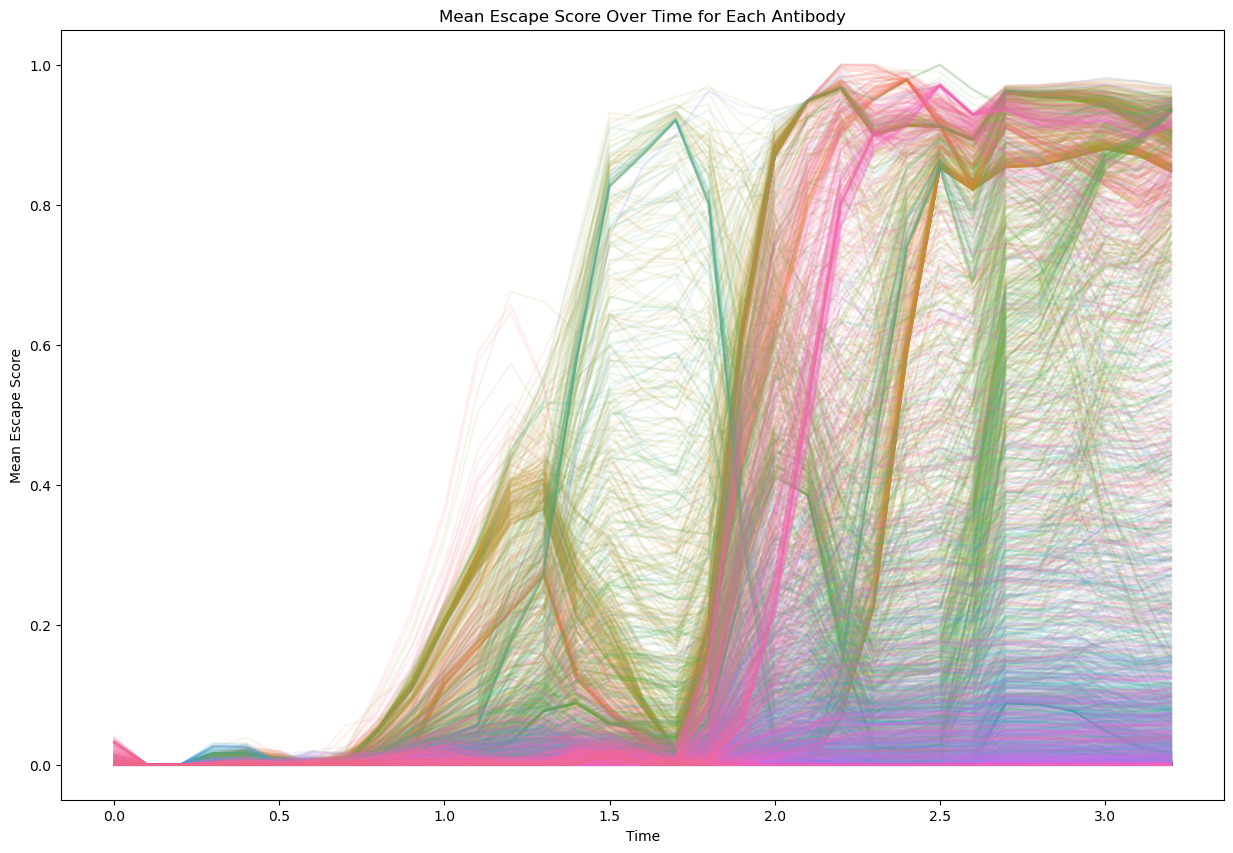

In [6]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=ab_window_data, x='time', y='mean_escape', hue='antibody', legend=False, alpha=.1)

plt.title('Mean Escape Score Over Time for Each Antibody')
plt.xlabel('Time')
plt.ylabel('Mean Escape Score')
plt.show()

Doing the nxn matrix for ewuclidian distance

In [7]:
# import numpy as np
# import pandas as pd


# # This function calculates the Euclidean distance between two vectors (vec1 and vec2).
# # The distance is calculated as the square root of the sum of squared differences between corresponding elements of the vectors.
# def euclidean_distance(vec1, vec2):
#     return np.sqrt(np.sum((vec1 - vec2) ** 2))

# # Identify all unique antibodies in our dataset.
# antibodies = ab_window_data['antibody'].unique()

# # Create an empty dictionary called 'antibody_dict'.
# # This dictionary will store the trajectory of mean_escape values for each antibody.
# antibody_dict = {}
# # Loop through each unique antibody to populate the dictionary.
# for ab in antibodies:
#     # Filter the rows in ab_window_data where the antibody is the one we're looking at ('ab').
#     # Sort these rows based on the 'time' column.
#     # Extract the 'mean_escape' values into a NumPy array.
#     # Store this array in the 'antibody_dict' dictionary under the key named after the antibody.
#     traj = ab_window_data[ab_window_data['antibody'] == ab].sort_values(by='time')['mean_escape'].values
#     antibody_dict[ab] = traj

# # Create an empty DataFrame called 'distance_matrix'.
# # The row and column names are the unique antibodies.
# # This DataFrame will be used to store the Euclidean distances between each pair of antibodies.
# distance_matrix = pd.DataFrame(index=antibodies, columns=antibodies)

# # Start a nested loop to go through each pair of antibodies.
# # For each pair (ab1, ab2), we will calculate the Euclidean distance between their trajectories.
# for ab1 in antibodies:
#     for ab2 in antibodies:
#         # If the antibodies are the same, the distance is zero.
#         if ab1 == ab2:
#             distance_matrix.loc[ab1, ab2] = 0.0
#         else:
#             # If the antibodies are different, we fetch their trajectories from 'antibody_dict'.
#             traj1 = antibody_dict[ab1]
#             traj2 = antibody_dict[ab2]
            
            
            
#             # Calculate the Euclidean distance between the two trajectories using our function from before.
#             # Store this distance value in the corresponding cell of the 'distance_matrix' DataFrame.
#             distance = euclidean_distance(traj1, traj2)
#             distance_matrix.loc[ab1, ab2] = distance

# # Print out the filled 'distance_matrix' DataFrame, which now contains the Euclidean distances between each pair of antibodies.
# print(distance_matrix)




In [8]:
# distance_matrix.head()
# distance_matrix.to_csv('distance_matrix.csv')


In [9]:
# !pip install umap-learn


In [10]:
# !conda install -y numpy=1.24



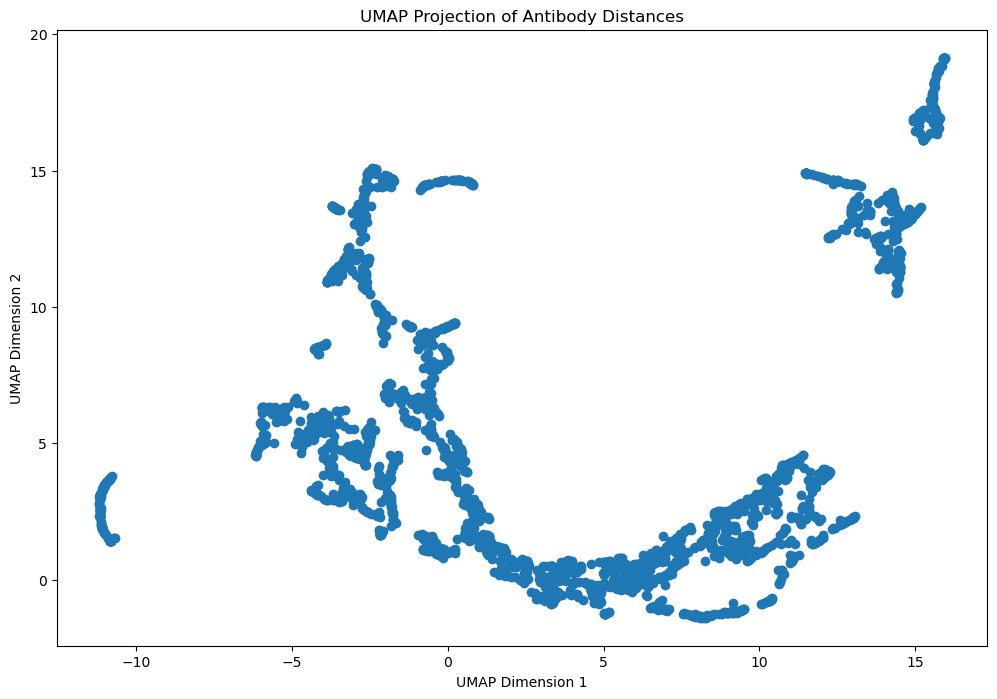

In [12]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Read the saved distance_matrix from the CSV file
distance_matrix = pd.read_csv('distance_matrix.csv', index_col=0)

# make sure the dataframe is of type float
distance_matrix = distance_matrix.astype(float)

# Create a UMAP model
umap_model = umap.UMAP(metric='precomputed')  # Using precomputed cuz we have a distance matrix

# Fit the model to data 
embedding = umap_model.fit_transform(distance_matrix)

# Extract the 2D coordinates
x_coords = embedding[:, 0]
y_coords = embedding[:, 1]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)


plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Antibody Distances')

plt.show()


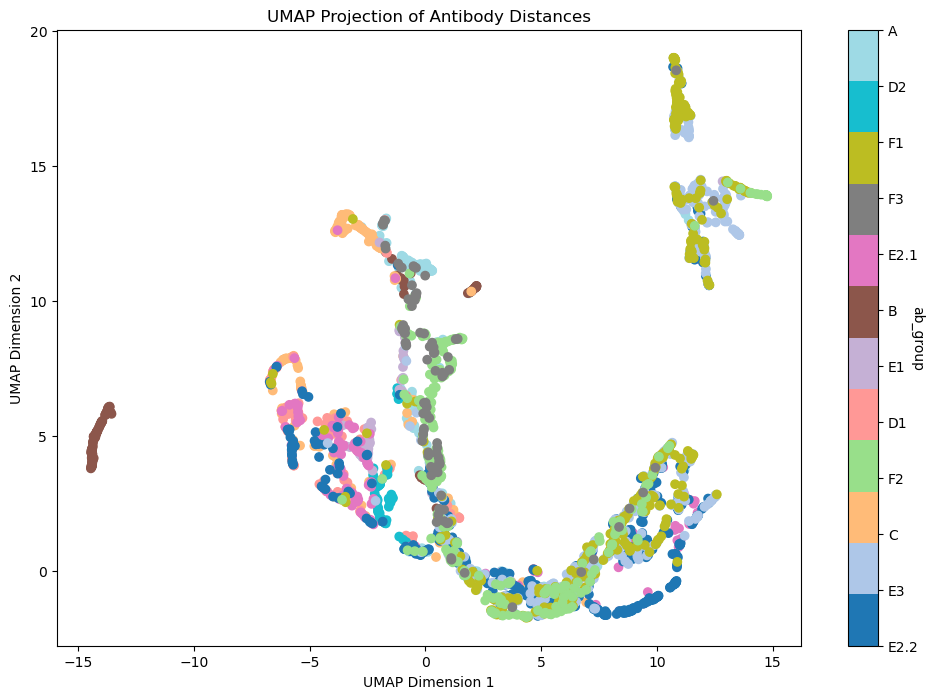

In [21]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Read the saved distance_matrix from the CSV file
distance_matrix = pd.read_csv('distance_matrix.csv', index_col=0)

# Make sure the dataframe is of type float
distance_matrix = distance_matrix.astype(float)

# Assuming ab_window_data has columns 'antibody' and 'ab_group'
# Create a dictionary to map antibody names to their ab_group
ab_to_group_dict = dict(zip(ab_window_data['antibody'], ab_window_data['ab_group']))

# Map the antibodies in the distance_matrix to their corresponding ab_group
colors = [ab_to_group_dict.get(ab, 'Unknown') for ab in distance_matrix.index]

# Create a color map for unique ab_groups
unique_ab_groups = list(set(colors))
color_map = {ab_group: idx for idx, ab_group in enumerate(unique_ab_groups)}

# Map each data point to its ab_group color index
colors = [color_map[ab_group] for ab_group in colors]

# Create a UMAP model
umap_model = umap.UMAP(metric='precomputed')

# Fit the model to data 
embedding = umap_model.fit_transform(distance_matrix)

# Extract the 2D coordinates
x_coords = embedding[:, 0]
y_coords = embedding[:, 1]

# Create a scatter plot
plt.figure(figsize=(12, 8))
sc = plt.scatter(x_coords, y_coords, c=colors, cmap=plt.cm.get_cmap('tab20', len(unique_ab_groups)))

# Create color bar
cbar = plt.colorbar(sc, ticks=range(len(unique_ab_groups)))
cbar.set_label('ab_group', rotation=270)
cbar.set_ticklabels(unique_ab_groups)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Antibody Distances')

plt.show()


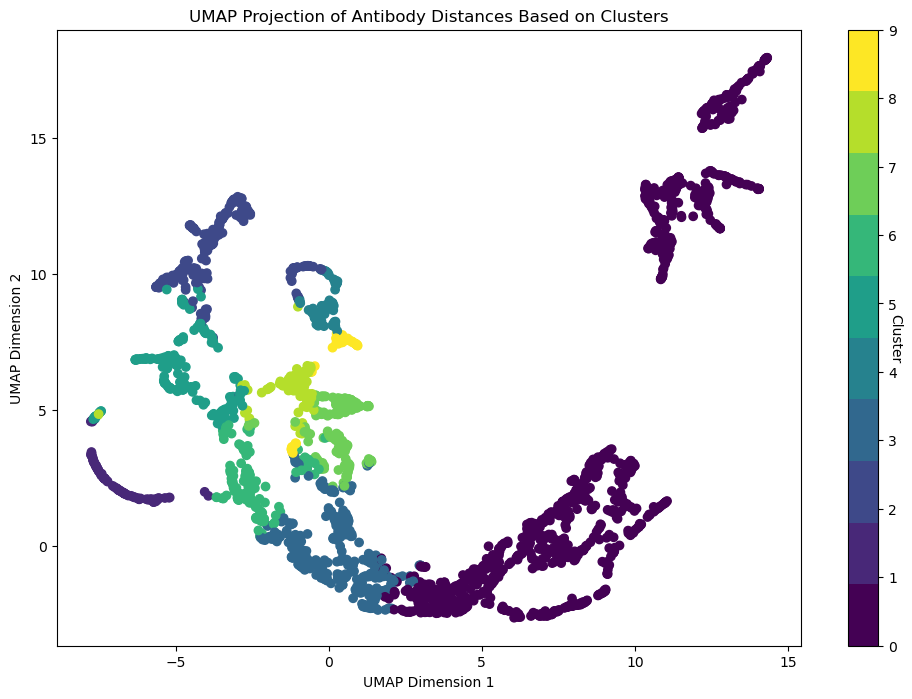

In [29]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Read the saved distance_matrix from the CSV file
distance_matrix = pd.read_csv('distance_matrix.csv', index_col=0)

# Read the antibody_cluster_df CSV file
antibody_cluster_df = pd.read_csv('antibody_cluster_df.csv')

# Make sure the dataframe is of type float
distance_matrix = distance_matrix.astype(float)

# Create a dictionary to map antibody names to their clusters
ab_to_cluster_dict = dict(zip(antibody_cluster_df['Antibody'], antibody_cluster_df['Cluster']))

# Map the antibodies in the distance_matrix to their corresponding cluster
colors = [ab_to_cluster_dict.get(ab, 'Unknown') for ab in distance_matrix.index]

# Create a color map for unique clusters
unique_clusters = list(set(colors))
color_map = {cluster: idx for idx, cluster in enumerate(unique_clusters)}

# Map each data point to its cluster color index
colors = [color_map[cluster] for cluster in colors]

# Create a UMAP model
umap_model = umap.UMAP(metric='precomputed')

# Fit the model to data 
embedding = umap_model.fit_transform(distance_matrix)

# Extract the 2D coordinates
x_coords = embedding[:, 0]
y_coords = embedding[:, 1]

# Create a scatter plot
plt.figure(figsize=(12, 8))
sc = plt.scatter(x_coords, y_coords, c=colors, cmap=plt.cm.get_cmap('viridis', len(unique_clusters)))

# Create color bar
cbar = plt.colorbar(sc, ticks=range(len(unique_clusters)))
cbar.set_label('Cluster', rotation=270)
cbar.set_ticklabels(unique_clusters)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Antibody Distances Based on Clusters')

plt.show()


## K-Means Clustering on Antibody Escape Data Over Time

Now, we'll walk through the following steps:

1. **Data Pivoting**: Reshaping the dataset to set each antibody as a row and time points as columns.
2. **Optimal Cluster Determination**: Using the Elbow method to deduce the best cluster count for K-Means.
3. **K-Means Clustering**: Applying K-Means based on the optimal or pre-defined cluster count.
4. **Visualization**: Plotting the resulting clusters to observe antibody behavior over time.


# To start, pivot the dataframe to have one row per antibody and one column per time point

In [22]:
pivot_df = ab_window_data.pivot(index=['antibody', 'ab_group'], columns= 'time', values='mean_escape').fillna(0)
pivot_df.head()

time                    0.0  0.1  0.2       0.3       0.4       0.5       0.6  \
antibody ab_group                                                               
1-57     D1        0.000000  0.0  0.0  0.000199  0.000659  0.000466  0.000000   
2-15     C         0.000000  0.0  0.0  0.015625  0.015152  0.000000  0.000000   
7D6      C         0.000000  0.0  0.0  0.015625  0.015152  0.000000  0.000000   
ADG-2    F3        0.029848  0.0  0.0  0.002077  0.002014  0.000000  0.002413   
B38      A         0.000000  0.0  0.0  0.005264  0.024388  0.019283  0.000000   

time                    0.7       0.8       0.9  ...       2.3       2.4  \
antibody ab_group                                ...                       
1-57     D1        0.001060  0.002654  0.007889  ...  0.051163  0.048504   
2-15     C         0.000000  0.050000  0.111464  ...  0.905975  0.916940   
7D6      C         0.000000  0.050000  0.108108  ...  0.900000  0.913043   
ADG-2    F3        0.002368  0.008737  0.019526  ...  0.918549  0.885225   
B38      A         0.005145  0.044115  0.099816  ...  0.994930  0.982737   

time                    2.5       2.6       2.7       2.8       2.9       3.0  \
antibody ab_group                                                               
1-57     D1        0.056571  0.168434  0.225069  0.268755  0.385906  0.546923   
2-15     C         0.913522  0.894991  0.962195  0.959045  0.958695  0.951932   
7D6      C         0.911765  0.892857  0.959815  0.955176  0.952142  0.941461   
ADG-2    F3        0.884084  0.899603  0.856059  0.838483  0.814406  0.754451   
B38      A         0.947900  0.928571  0.965233  0.968423  0.970834  0.961822   

time                    3.1       3.2  
antibody ab_group                      
1-57     D1        0.635897  0.744227  
2-15     C         0.935824  0.920847  
7D6      C         0.918737  0.891953  
ADG-2    F3        0.744743  0.822356  
B38      A         0.953200  0.947968  

[5 rows x 33 columns]

### Determining the Optimal Number of Clusters
Here, we're employing the Elbow method. This visual technique helps find the number of clusters where the rate of reduction in distortion slows down, suggesting an optimal cluster count.


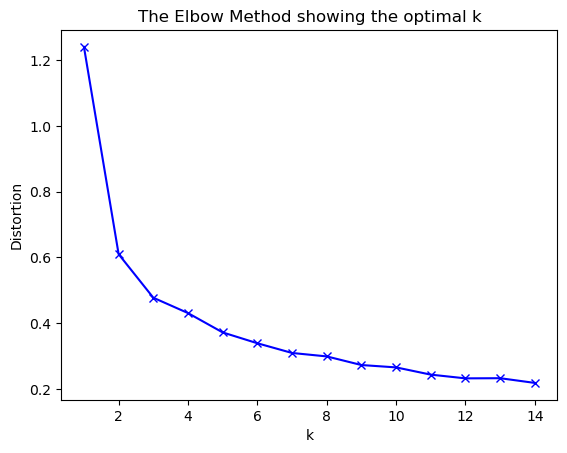

In [23]:
# Compute optimal number of clusters using Elbow method
distortions = []
K = range(1,15) # This range can be adjusted depending on use case
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(pivot_df)
    distortions.append(sum(np.min(cdist(pivot_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pivot_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## Interpretation of the Plot

* The "elbow" is observed to occur within the 2-4k range, suggesting that 2-4 is the optimal number of clusters.
* For this analysis, we've chosen 12 clusters. The rationale behind this choice will be shown in the upcoming cells.


### K-Means Clustering Application
After deducing or choosing the number of clusters, we proceed to segment the data using K-Means.


In [24]:
# Pick the optimal number of clusters by examining the elbow plot
n_clusters = 10 # change this based on your elbow plot result

#NOTE: we chose a large K value due to the large dataset we used

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter = 8000).fit(pivot_df)

# Add the cluster labels back into the pivot dataframe
pivot_df['cluster'] = kmeans.labels_


### Visualizing Clustering Results
For each identified cluster, we visualize antibodies over time. This allows us to observe patterns and compare the behavior of different antibodies and antibody groups.


First we will make a dataframe that will be able to hold the average trajecotries that will be portrayed in each cluster:

In [26]:
mean_trajectory_df = pd.DataFrame(columns=['cluster', 'time', 'mean_value'])

Now lets plot the clusters and record the mean trajecotory data in our new data frame

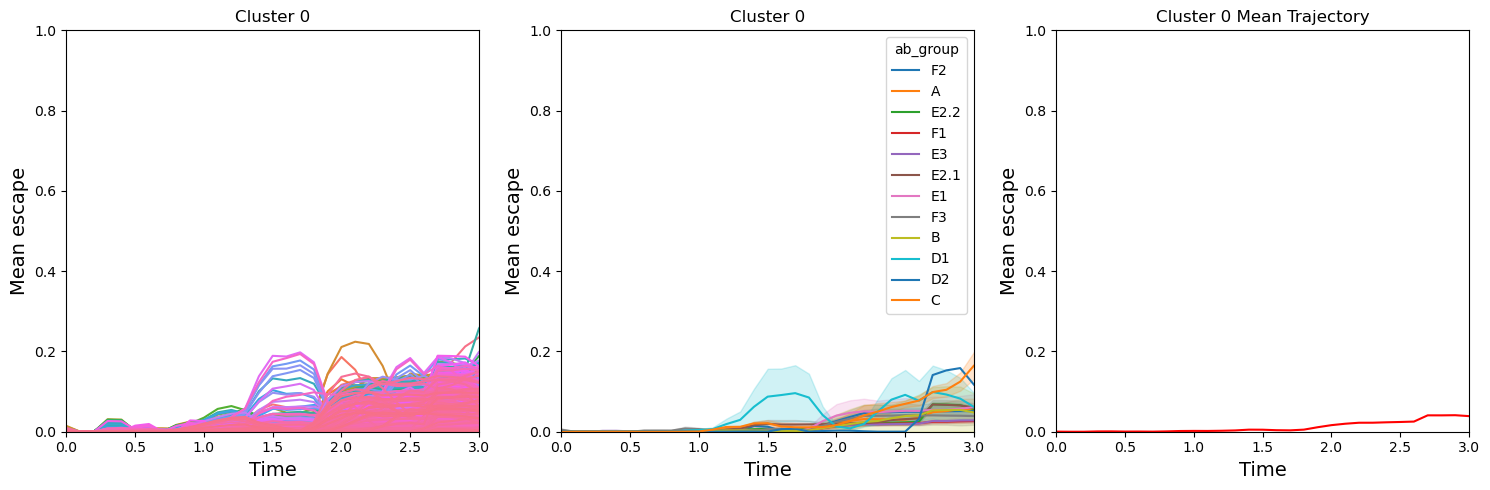

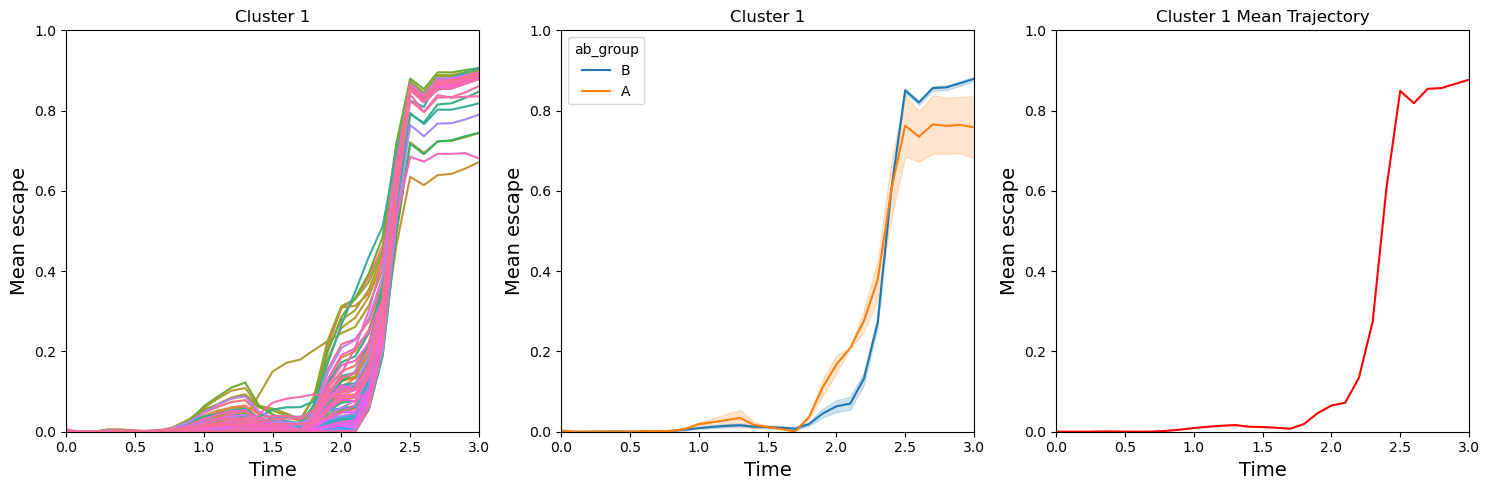

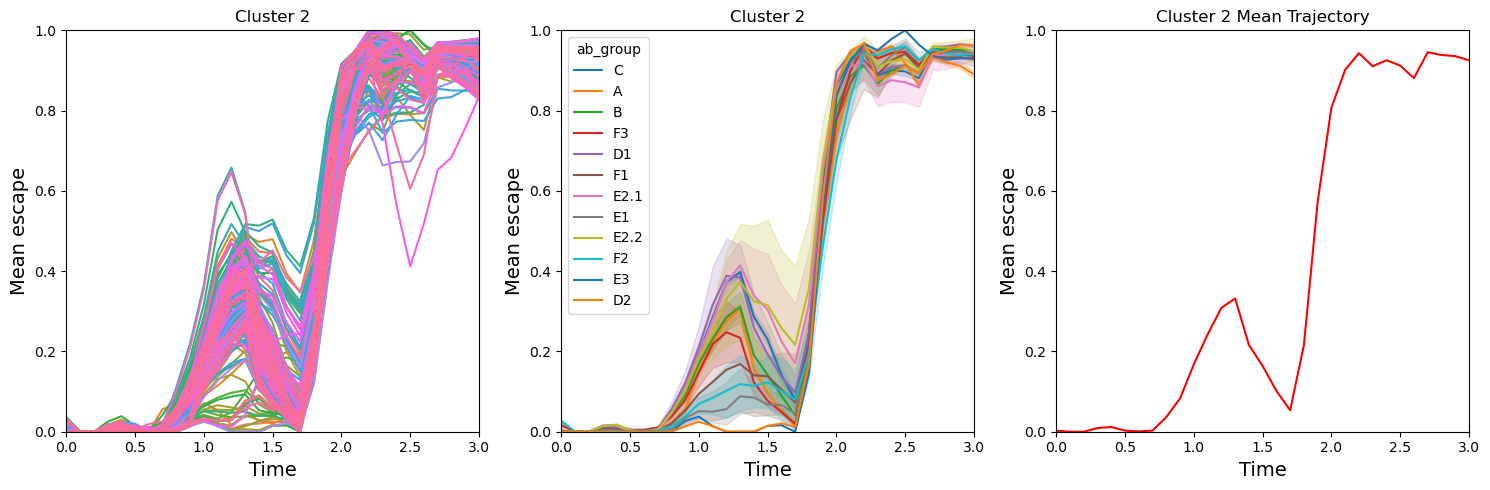

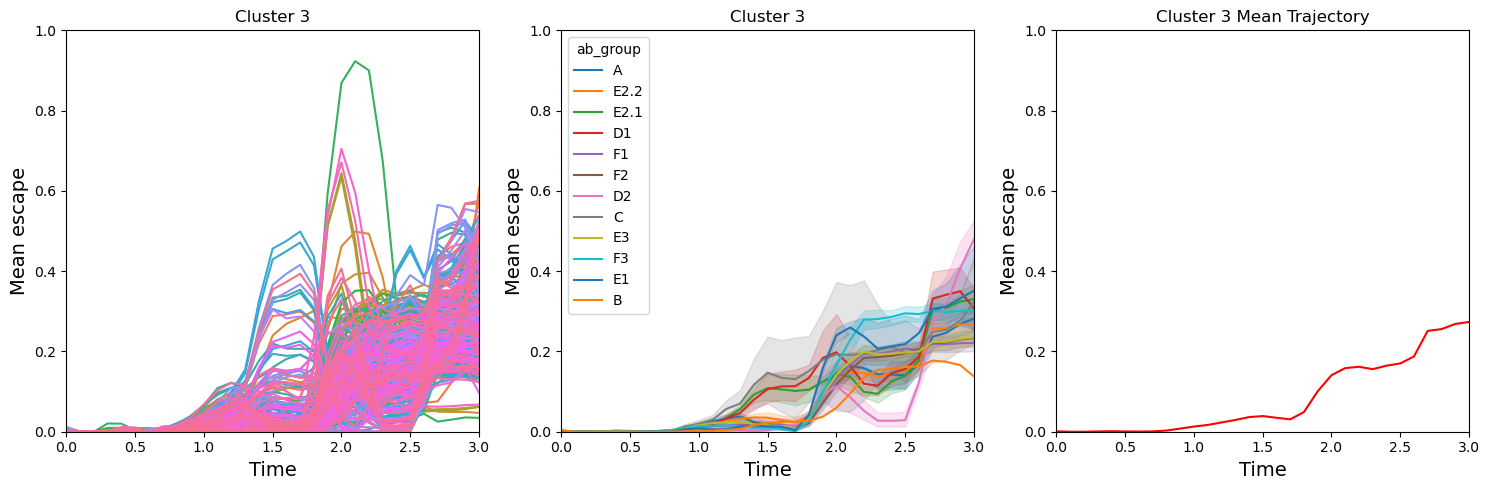

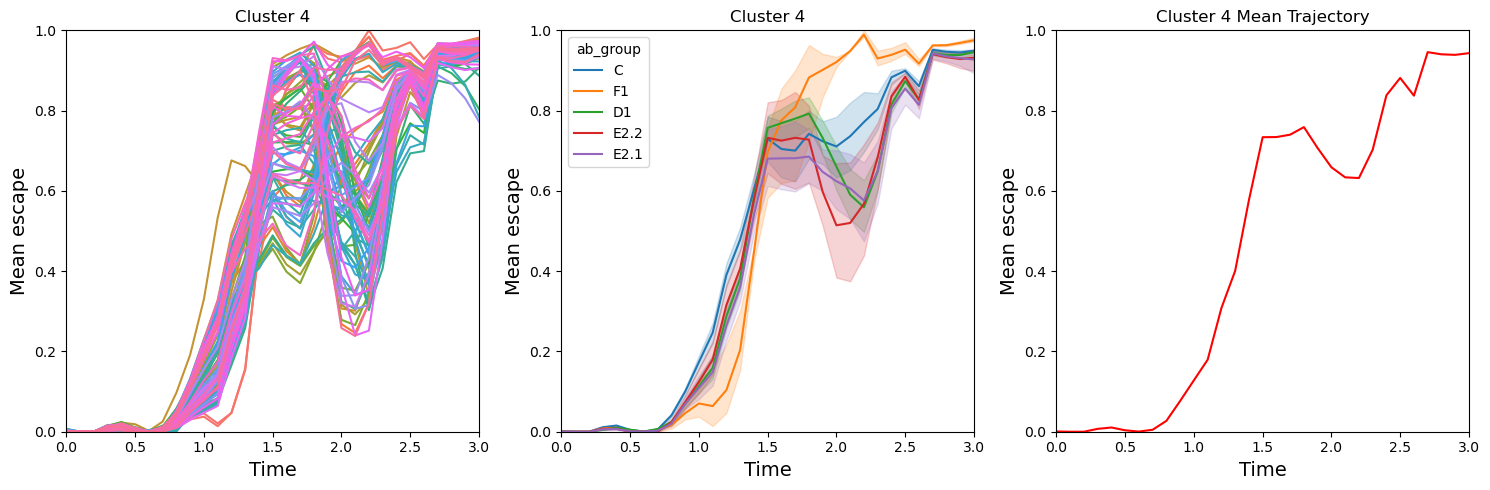

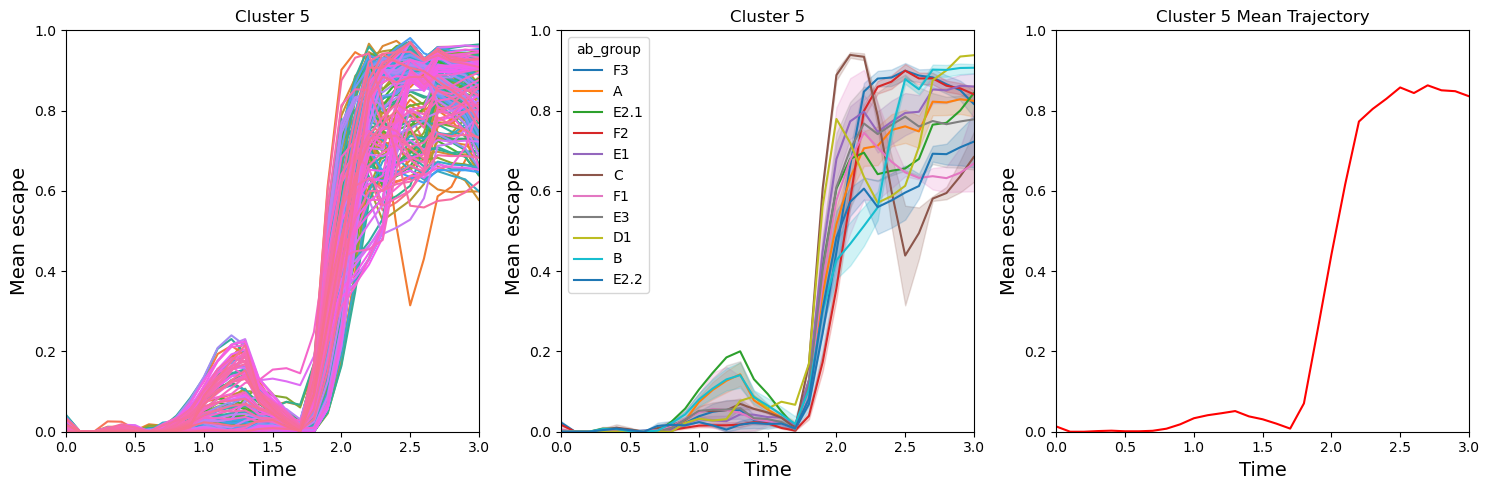

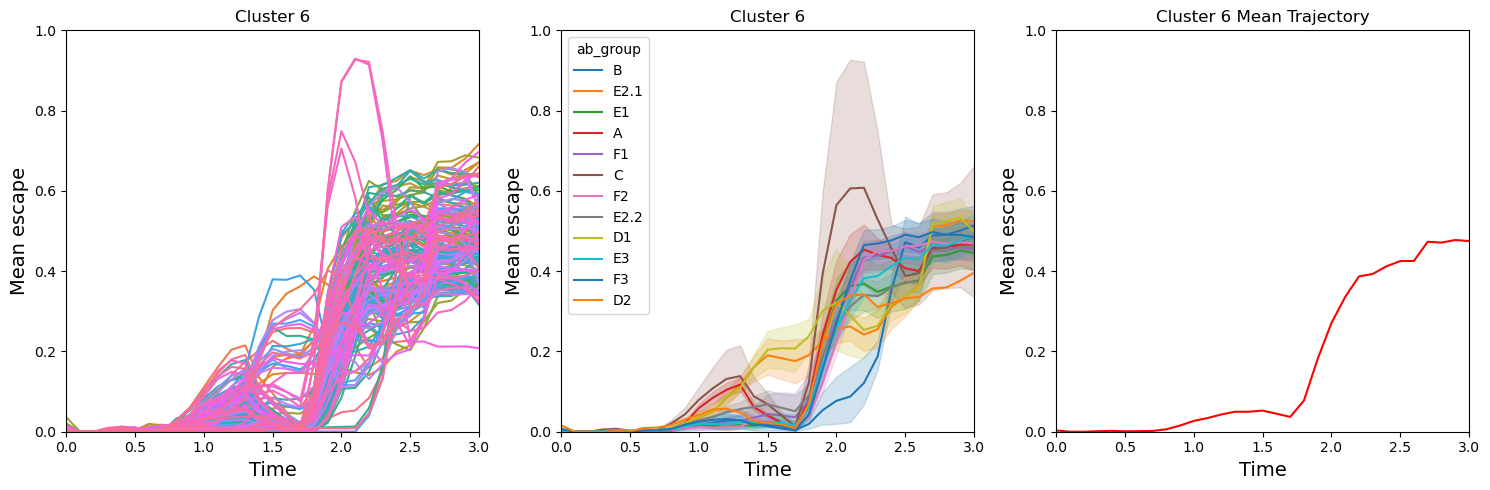

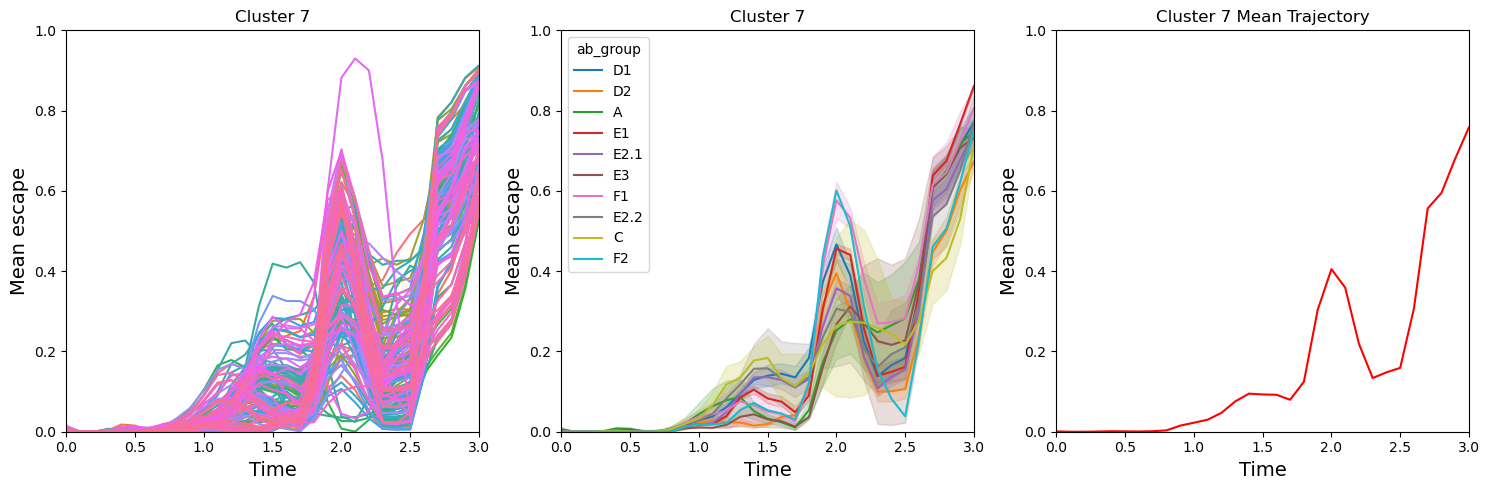

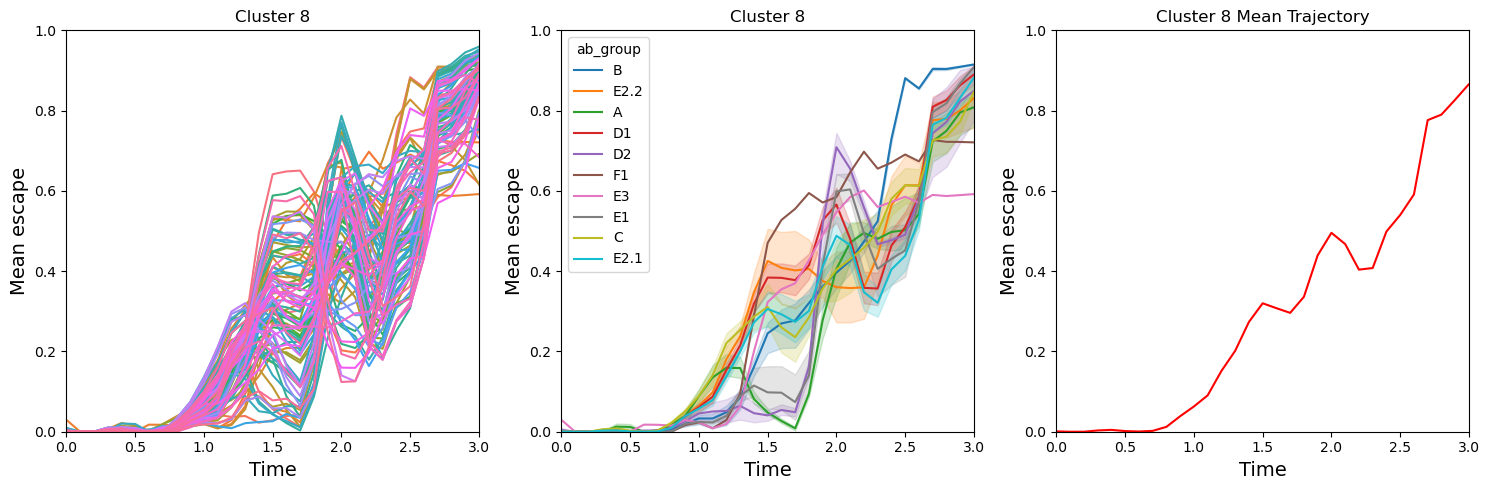

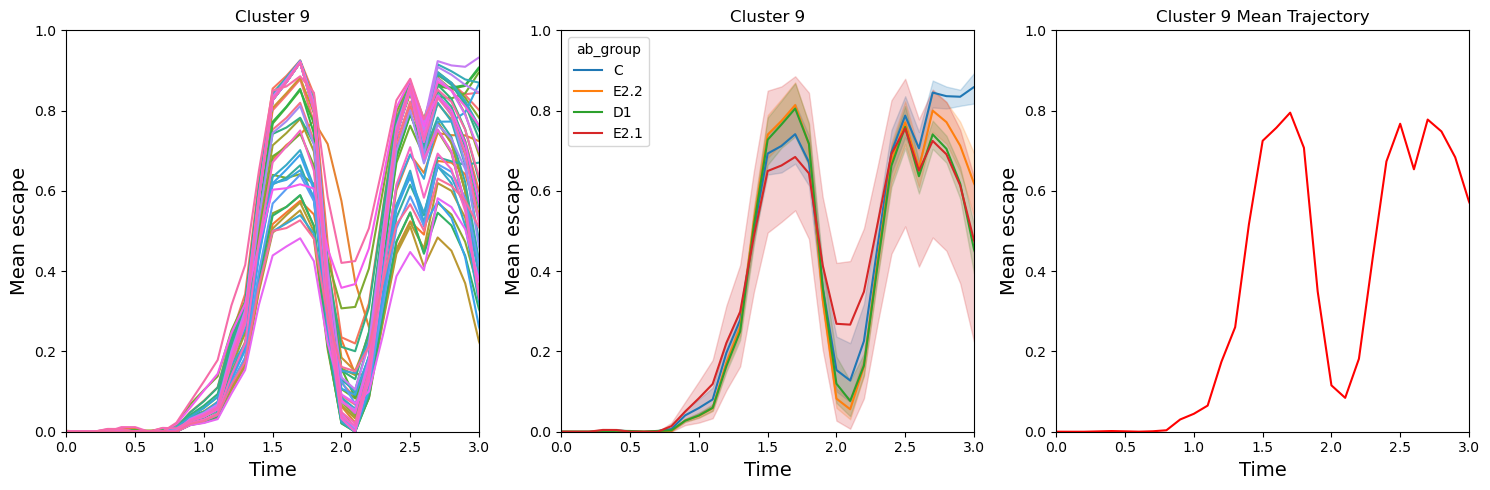

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize an empty DataFrame for storing mean trajectory data
mean_trajectory_df = pd.DataFrame()

# Initialize a dictionary to hold the count of antibodies in each cluster
antibody_count_per_cluster = {}

# DataFrame to store the antibody-cluster mapping
antibody_cluster_df = pd.DataFrame(columns=['Cluster', 'Antibody'])  # New Line

# Assuming 'n_clusters' and 'pivot_df' are already defined
for cluster in range(n_clusters):
    cluster_df = pivot_df[pivot_df['cluster'] == cluster].drop(columns='cluster').reset_index()
    cluster_df = cluster_df.melt(id_vars=['ab_group', 'antibody'])
    cluster_df.time = cluster_df.time.astype(float)
    
    # Count the number of unique antibodies in this cluster and update the dictionary
    num_antibodies = cluster_df['antibody'].nunique()
    antibody_count_per_cluster[cluster] = num_antibodies
    
    # Get the unique antibodies in this cluster
    unique_antibodies = cluster_df['antibody'].unique()  
    
    # Create a DataFrame mapping each unique antibody to this cluster
    temp_df = pd.DataFrame({'Cluster': [cluster]*len(unique_antibodies), 'Antibody': unique_antibodies})  # New Line
    
    # Append this mapping to antibody_cluster_df
    antibody_cluster_df = pd.concat([antibody_cluster_df, temp_df], ignore_index=True)  # New Line
    
    # Calculate mean trajectory for this cluster
    mean_trajectory = cluster_df.groupby('time')['value'].mean().reset_index()
    mean_trajectory['cluster'] = cluster
    
    # Append the mean trajectory to the DataFrame
    mean_trajectory_df = pd.concat([mean_trajectory_df, mean_trajectory.rename(columns={'value': 'mean_value'})])
    
    # Start subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Normal plot with all antibodies in the cluster
    sns.lineplot(data=cluster_df, x='time', y='value', hue='antibody', ax=axs[0], legend=False)
    axs[0].set_title(f'Cluster {cluster}')
    axs[0].set_xlabel('Time', fontsize=14)
    axs[0].set_ylabel('Mean escape', fontsize=14)
    
    # Plot classified by antibody group
    sns.lineplot(data=cluster_df, x='time', y='value', hue='ab_group', palette='tab10', ax=axs[1])
    axs[1].set_title(f'Cluster {cluster}')
    axs[1].set_xlabel('Time', fontsize=14)
    axs[1].set_ylabel('Mean escape', fontsize=14)
    
    # Plot displaying mean trajectory
    sns.lineplot(data=cluster_df, x='time', y='value', ci=None, estimator=np.mean, color='r', ax=axs[2])
    axs[2].set_title(f'Cluster {cluster} Mean Trajectory')
    axs[2].set_xlabel('Time', fontsize=14)
    axs[2].set_ylabel('Mean escape', fontsize=14)
    
    # set x and y axis limits
    axs[0].set_xlim([0, 3])
    axs[0].set_ylim([0, 1])
    axs[1].set_xlim([0, 3])
    axs[1].set_ylim([0, 1])
    axs[2].set_xlim([0, 3])
    axs[2].set_ylim([0, 1])
    
    # Show the plot
    plt.tight_layout()
    plt.show()



new 


In [28]:
antibody_cluster_df.to_csv('antibody_cluster_df.csv')

Bar chart representing the number of antibodies in each cluster

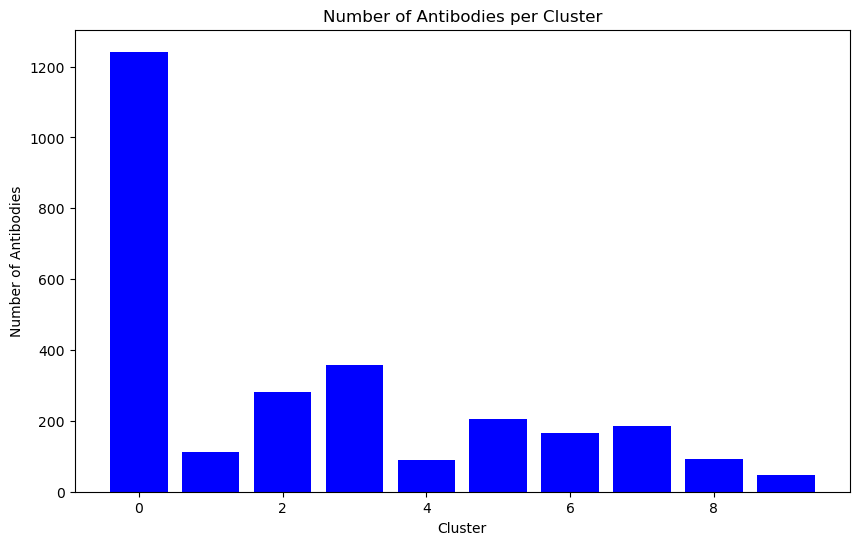

In [12]:
# Plotting the bar chart showing the number of antibodies in each cluster
plt.figure(figsize=(10,6))
plt.bar(antibody_count_per_cluster.keys(), antibody_count_per_cluster.values(), color='b')
plt.xlabel('Cluster')
plt.ylabel('Number of Antibodies')
plt.title('Number of Antibodies per Cluster')
plt.show()

Now, using the mean trajctory Data Frame we created above and the data we filled it with from each cluster iteration, lets plot all the trajectories and see how they compare using a seaborne function called relplot:

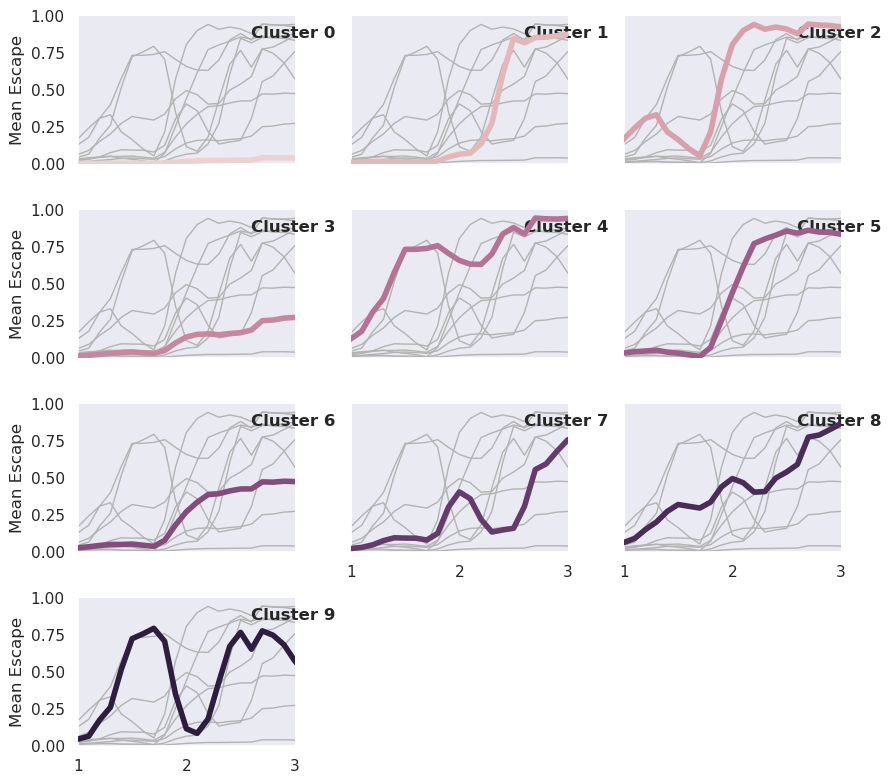

In [13]:
#Inspiration for this code came from https://seaborn.pydata.org/examples/timeseries_facets.html

# Set theme
sns.set_theme(style="dark")

# Create the relplot
g = sns.relplot(
    data=mean_trajectory_df,
    x="time", y="mean_value", col="cluster", hue="cluster",
    kind="line", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for cluster, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, f"Cluster {cluster}", transform=ax.transAxes, fontweight="bold")

    # Plot all clusters' time series in the background (this is optional)
    sns.lineplot(
        data=mean_trajectory_df, x="time", y="mean_value", units="cluster",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    
    # Set x and y axis limits for each subplot
    ax.set_xlim([1, 3])
    ax.set_ylim([0, 1])
    
# make the ticks less
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Mean Escape")
g.tight_layout()

plt.show()


## Analysis of the Results 

* The data exhibits multiple variations of patterns spanning the last ~3000 antibodies graphed.
* Clusters do not align perfectly with antibody groups. This means that an antibody's group classification doesn't necessarily dictate its pattern.
* There's a noticeable dip in some graphs around the 2-year mark. This coincides with the emergence of the Omicron variant.
    * Prior to Omicron, a succession of variants of concern emerged. Each new variant repplaced its predecessor.
    * Omicron's eventual dominance suggests its initial lack of adaptation. However, subsequent peaks in the data may indicate Omicron's evolutionary adaptations over time.
* To further explain the rationale behind 12 clusters, we can see in the result that in each of the 12 clusters, there is a unique pattern or trajectory. These sort of results would not have been revealed if we had chosen smaller K value. The reason i belive teh elbow plot was not super representative of the actual clusters taht were neccissary is due to our larger data set. 


Read in data on IC50 values of antibodies and create the histogram

Updated Antibody-Cluster-IC50 Mapping:
     Cluster       Antibody    IC_50
0          0         BD-320   2.4900
1          0         BD-369   0.0130
2          0         BD-505   0.0147
3          0         BD-508   0.0271
4          0         BD-695  10.0000
...      ...            ...      ...
2773       9       BD57-070   0.0670
2774       9       BD57-085   0.1540
2775       9  Ehling_mAb-82   1.0700
2776       9       TAU-2220  10.0000
2777       9        XGv-212   0.1620

[2778 rows x 3 columns]


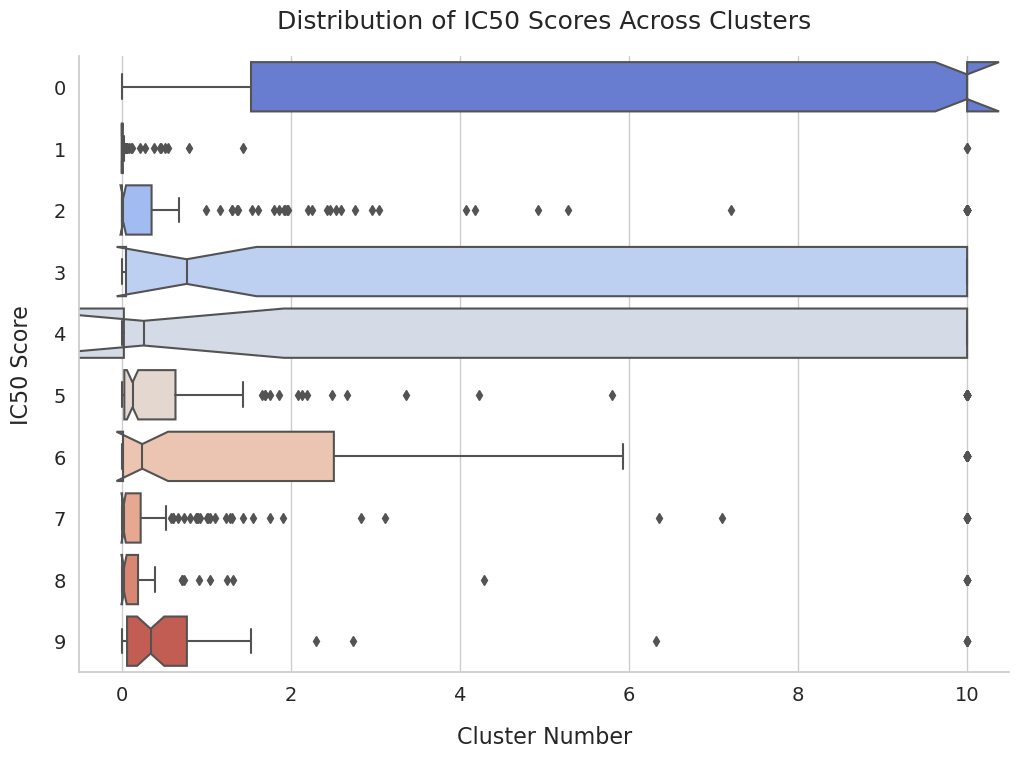

In [14]:
ic50_df = pd.read_csv('data/ncov_escape_scores/antibody_IC50s.csv')
ic50_df = ic50_df[ic50_df['virus'] == 'D614G']
ic50_df.head()


# Merge antibody_cluster_df with ic50_df to get IC50 scores for each antibody
merged_df = pd.merge(antibody_cluster_df, ic50_df[['antibody', 'IC50']], 
                     left_on='Antibody', right_on='antibody', how='left').drop(columns=['antibody'])

# Rename the IC50_Score column to IC_50
merged_df.rename(columns={'IC50': 'IC_50'}, inplace=True)

# Now, merged_df should contain the cluster, antibody name, and corresponding IC_50 scores for each antibody
print("Updated Antibody-Cluster-IC50 Mapping:")
print(merged_df)

import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall aesthetic.
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

# Create the boxplot with custom colors
sns.boxplot(x='IC_50', y='Cluster', data=merged_df, palette="coolwarm", orient="h", notch=True)

# Remove the top and right spines for cleanliness
sns.despine(top=True, right=True, left=False, bottom=False)

# Add labels and title
plt.xlabel('Cluster Number', fontsize=16, labelpad=15)
plt.ylabel('IC50 Score', fontsize=16, labelpad=15)
plt.title('Distribution of IC50 Scores Across Clusters', fontsize=18, pad=20)

# Customize tick labels
plt.tick_params(labelsize=14)

# Show the plot
plt.show()


## Visualizing Antibody Group Density Across Clusters

In this section, we aim to visualize the distribution and density of different antibody groups across the clusters identified previously.

The steps are as follows:

1. **Data organization**: Group the pivoted data based on the cluster and antibody group.
2. **Normalization**: Normalize the grouped data to get the fraction of each antibody group in every cluster.
3. **Heatmap Generation**: Create a cluster map (a type of heatmap) to visually represent the density of each antibody group across clusters.


### Data organization 
First, let's organize the data to get a count of each antibody group in every cluster. The count is then converted to percentages for easier interpretation.

In [15]:
# Create a new dataframe to hold cluster vs ab_group counts
cluster_ab_group_df = pivot_df.groupby(['cluster', 'ab_group']).size().unstack(fill_value=0)

# Normalize the counts to represent fractions within each cluster
cluster_ab_group_df = cluster_ab_group_df.div(cluster_ab_group_df.sum(axis=1), axis=0)

# Convert fractions to percentages
cluster_ab_group_df = cluster_ab_group_df * 100

### Generating the Cluster Map
Using Seaborn's `clustermap` function, we'll visualize the density of each antibody group across different clusters. The color gradient (from white to black) indicates the density percentage.


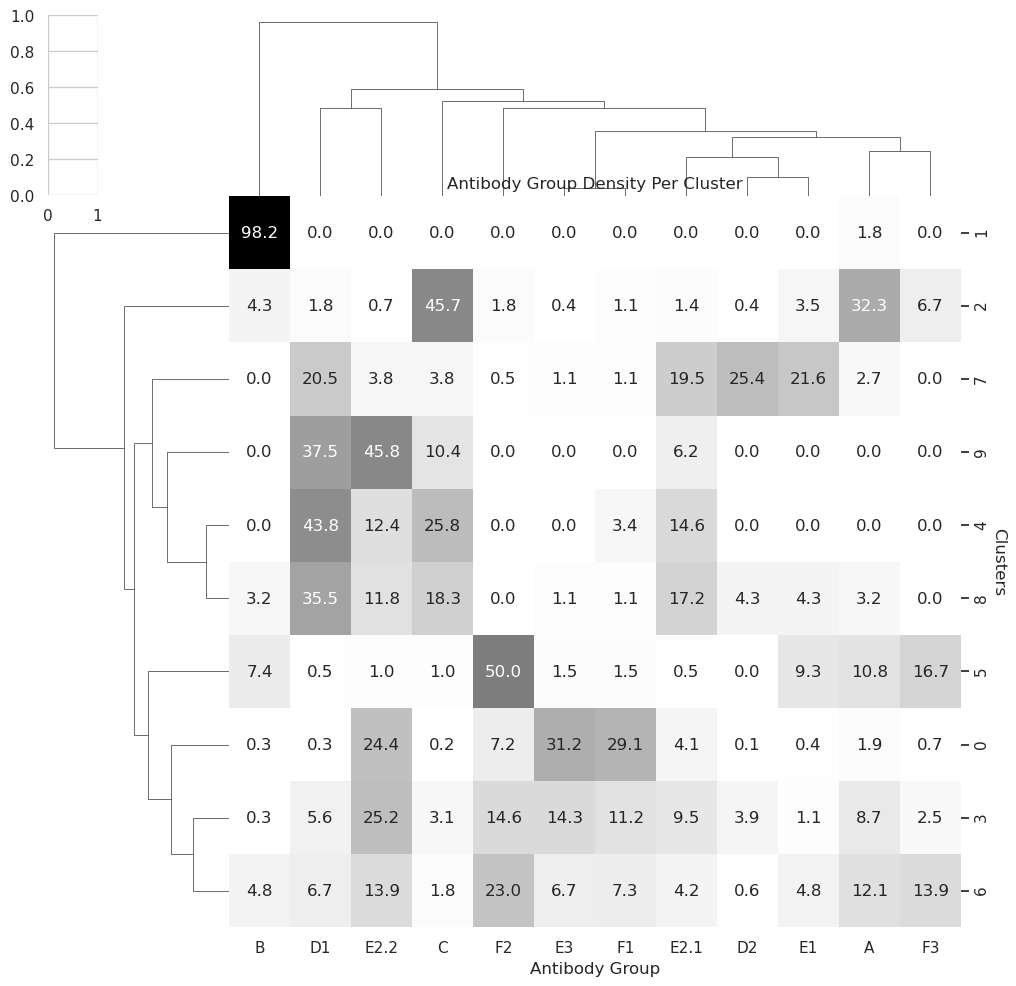

In [16]:
# Making a color gradient
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])

# Initializing the ClusterMap
g = sns.clustermap(cluster_ab_group_df, annot=True, fmt=".1f", row_cluster=True, col_cluster=True, cmap=cmap, cbar=False)

# Making x-axis label on bottom
g.ax_heatmap.set_xlabel('Antibody Group') 

# Making y-axis label on the right
g.ax_heatmap.set_ylabel('Clusters', rotation=-90, va="baseline")

# Setting the title for the clustermap
g.ax_heatmap.set_title('Antibody Group Density Per Cluster')

plt.show()


## What to deduce from the cluster map
* Antibody group B, has high density in one specific cluster.
* Other antibody groups are widely spread, displaying varying density levels across clusters.
* Antibody group D1, E2.2, and C exhibits higher density levels in multiple clusters.
* Antibody group E2.1 presents a moderate density spread across several clusters.


## Insights from Cluster Analysis
* Initially, one might assume that each cluster would correspond directly to a specific antibody group.
* However, post-analysis reveals that clusters don't align neatly with antibody groups. Instead, the data unveils diverse patterns and correlations across various graphs.
* Some antibody groups span multiple clusters, while others predominantly populate a single cluster.
* These findings open a plethora of avenues for interpretation and further study.